In [1]:
import pandas as pd
import numpy as np
from joblib import load
from scipy.sparse import vstack, hstack, csr_matrix
from scipy.stats import sem, mannwhitneyu
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedKFold
from sklearn.metrics import precision_score, roc_auc_score
import xgboost

In [2]:
data_version = 1

In [3]:
data = load(f'./data/glaw/data_vectorized_{data_version}.sav')
data_headers_dict = load(f'./data/glaw/data_headers_{data_version}.sav')['vocabulary_']
df_labels = pd.read_csv(f'./data/glaw/labels_{data_version}.csv', index_col=0)
print(len(data))
print(len(data_headers_dict))
df_labels.head()

419
4135


,labels
0,"[0, 0, 0, 1, 0]"
1,"[0, 0, 1, 0]"
2,"[0, 0, 1]"
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,"[1, 0, 0, 0]"


In [4]:
df_labels['labels'] = df_labels['labels'].apply(eval)
labels = df_labels['labels'].to_numpy()
print(len(labels))

data = np.array(data)
print(len(data))

headers = sorted(data_headers_dict.keys(), key=lambda key: data_headers_dict[key])
headers_concurrent = list(map(lambda h: f'{h}_concurrent', headers))
print(len(headers), len(headers_concurrent))

419
419
4135 4135


In [5]:
def reveal_sparse(sparse_list):
    return vstack(sparse_list, format='csr')

def reveal_np(np_list):
    return np.concatenate(np_list, axis=0)

def reveal_set(data_, labels_):
    return reveal_sparse(data_), reveal_np(labels_)

In [6]:
class CustomEstimator:
    def __init__(self, model=None, early_stopping=False):
        self.model = model
        self.early_stopping = early_stopping

    def fit(self, X, Y=None, **kwargs):
        train_data_revealed, train_labels_revealed = reveal_set(X, Y)
        kwargs = {}
        if self.early_stopping:
            kwargs['eval_set'] = [(train_data_revealed, train_labels_revealed)]
        self.model.fit(train_data_revealed, train_labels_revealed, **kwargs)

        if self.early_stopping:
            self.model.set_params(n_estimators=self.model.best_ntree_limit)

        return self

    def get_params(self, deep=False):
        return {'model': self.model, 'early_stopping': self.early_stopping}

    def set_params(self, **kwargs):
        self.model.set_params(**kwargs)

        return self

In [7]:
def evaluate(estimator, test_data_list, test_labels_list):
    """Evaluate estimator on each document from `test_data_list`

    :param estimator: sklearn estimator
    :param test_data_list: list of sparce matrices
    :param test_labels_list: 2d list of labels
    :return: precision and roc-auc scores (calculates by macro-averaging corresponding scores of each document)
    """
    precision_batch = []
    roc_auc_batch = []
    for test_data_batch, test_labels_batch in zip(test_data_list, test_labels_list):
        positive_class_proba = estimator.model.predict_proba(test_data_batch)[:, 1]

        max_p_idx = np.argmax(positive_class_proba)
        predicted_labels_batch = [0] * len(positive_class_proba)
        predicted_labels_batch[max_p_idx] = 1
        if len(test_labels_batch) == 1:
            print(test_labels_batch)
        precision_batch.append(precision_score(test_labels_batch, predicted_labels_batch))
        roc_auc_batch.append(roc_auc_score(test_labels_batch, positive_class_proba))

    return {
        'precision': np.average(precision_batch),
        'roc-auc': np.average(roc_auc_batch),
    }

In [8]:
def repeated_cross_validation(estimator, X, y, k=10, r=7, random_state=42, verbose=1):
    cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=random_state)
    result = cross_validate(
        estimator=estimator,
        X=X,
        y=y,
        scoring=evaluate,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True,
        return_estimator=True,
        error_score='raise',
    )

    return result

In [9]:
def repeated_grid_search(estimator, param_grid, X, y, k=10, r=7, random_state=42, verbose=1):
    cv = RepeatedKFold(n_splits=k, n_repeats=r, random_state=random_state)
    clf = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=evaluate,
        cv=cv,
        n_jobs=-1,
        verbose=verbose,
        return_train_score=True,
        error_score='raise',
        refit='precision',
    )
    clf.fit(X, y)

    return clf

In [10]:
def statistics_from_cv(cv_result):
    scores_precision = cv_result['test_precision']
    scores_roc_auc = cv_result['test_roc-auc']

    return {
        'precision mean': np.mean(scores_precision),
        'precision sem': sem(scores_precision),
        'roc-auc mean': np.mean(scores_roc_auc),
        'roc-auc sem': sem(scores_roc_auc),
    }

In [11]:
def enumerate_repeats(estimator, X, y, from_=1, to=11, k=10, random_state=42):
    print("%3s %15s %15s %15s %15s" % ('r', 'roc-auc mean', 'roc-auc sem', 'precision mean', 'precision sem'))
    for r in range(from_, to):
        cv_results = repeated_cross_validation(estimator, X, y, random_state=random_state, r=r, k=k, verbose=0)
        stats = statistics_from_cv(cv_results)

        print("%3d %15.10f %15.10f %15.10f %15.10f" % (
            r, stats['roc-auc mean'], stats['roc-auc sem'], stats['precision mean'], stats['precision sem']))

In [12]:
def compare_estimators(estimator_base, estimator_concurrent, data_base, data_concurrent_, labels_, k=10, r=7, verbose=1, critical_value=0.05):
    cv_results_base = repeated_cross_validation(estimator_base, data_base, labels_, verbose=verbose, r=r, k=k)
    stats_base = statistics_from_cv(cv_results_base)

    cv_results_concurrent = repeated_cross_validation(estimator_concurrent, data_concurrent_, labels_, verbose=verbose,  r=r, k=k)
    stats_concurrent = statistics_from_cv(cv_results_concurrent)

    u_statistic_precision, p_value_precision = mannwhitneyu(cv_results_base['test_precision'], cv_results_concurrent['test_precision'])
    u_statistic_roc_auc, p_value_roc_auc = mannwhitneyu(cv_results_base['test_roc-auc'], cv_results_concurrent['test_roc-auc'])

    return {
        'mannwhitneyu_precision': {
            'u_statistic': u_statistic_precision,
            'p_value': p_value_precision,
            'is_mean_different': bool(p_value_precision < critical_value),
        },
        'mannwhitneyu_roc_auc': {
            'u_statistic': u_statistic_roc_auc,
            'p_value': p_value_roc_auc,
            'is_mean_different': bool(p_value_roc_auc < critical_value),
        },
        'base': {
            **stats_base,
            'cv_results': cv_results_base,
        },
        'concurrent': {
            **stats_concurrent,
            'cv_results': cv_results_concurrent,
        },
    }

In [13]:
def compare_data(estimator, data_base, data_concurrent_, labels_, k=10, r=7, verbose=1, critical_value=0.05):
    return compare_estimators(estimator, estimator, data_base, data_concurrent_, labels_, k, r, verbose, critical_value)

In [14]:
def doc_concurrent_data(doc, binarize=False):
    concurrent_list = []
    n = doc.shape[0]
    for idx, candidate in enumerate(doc):
        concurrent_mask = [True] * n
        concurrent_mask[idx] = False
        concurrent_candidates = doc[concurrent_mask]
        concurrent = concurrent_candidates.sum(axis=0)
        if binarize:
            concurrent[concurrent > 0] = 1
        concurrent = csr_matrix(concurrent)
        concurrent_list.append(concurrent)

    concurrent_sparse = reveal_sparse(concurrent_list)
    result = hstack([doc, concurrent_sparse], format='csr')

    return result

In [15]:
data_concurrent = list(map(doc_concurrent_data, data))

In [16]:
data_concurrent_binarized = list(map(lambda it: doc_concurrent_data(it, True), data))

In [17]:
import json
from copy import deepcopy

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def save(res, file_name:str):
    with open(f'./data/output/{file_name}', 'w+') as f:
        dump_json = deepcopy(res)
        del dump_json['base']['cv_results']['estimator']
        del dump_json['concurrent']['cv_results']['estimator']
        json.dump(dump_json, f, cls=NumpyEncoder, indent=4)

In [85]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(verbose=1, warm_start=False, n_jobs=-1)
estimator_log_reg = CustomEstimator(log_reg)

In [45]:
# enumerate_repeats(estimator_mnb, data, labels)

  r    roc-auc mean     roc-auc sem  precision mean   precision sem
  1    0.9900983129    0.0033484331    0.9499419280    0.0108955498
  2    0.9901372814    0.0021072597    0.9511033682    0.0065657199
  3    0.9899145050    0.0018066414    0.9515098722    0.0052850223
  4    0.9901592988    0.0016874869    0.9516986063    0.0049297177
  5    0.9904302228    0.0014429992    0.9518234611    0.0042709168
  6    0.9902716210    0.0013120931    0.9510936895    0.0040184447
  7    0.9901215052    0.0012342610    0.9512609922    0.0036716427
  8    0.9902793857    0.0011084049    0.9516840883    0.0035430372
  9    0.9901032710    0.0010660393    0.9514905149    0.0032889453
 10    0.9900518335    0.0010352253    0.9518118467    0.0031552726


In [89]:
result_log_reg = compare_data(estimator_log_reg, data, data_concurrent, labels, r=9)
save(result_log_reg, 'result_log_reg.json')
result_log_reg

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.1s finished


{'mannwhitneyu': {'u_statistic': 3512.0,
  'p_value': 0.11588167487917357,
  'is_mean_different': False},
 'base': {'precision mean': 0.9493612078977932,
  'precision sem': 0.0033218711260030293,
  'roc-auc mean': 0.9900731171917557,
  'roc-auc sem': 0.0010282042790131032,
  'cv_results': {'fit_time': array([0.11996508, 0.15899658, 0.17299819, 0.19200277, 0.24500179,
          0.17600203, 0.18400168, 0.23999953, 0.20299602, 0.18999791,
          0.19399762, 0.17300057, 0.58900142, 0.53400064, 0.42900085,
          0.4380033 , 0.26698947, 0.49900174, 0.44199896, 0.37500095,
          0.29199958, 0.26400089, 0.24099994, 0.26999402, 0.45000148,
          0.50799918, 0.34599972, 0.46500039, 0.34899902, 0.36099863,
          0.30699825, 0.44674611, 0.55674624, 0.33374667, 0.44575405,
          0.28774524, 0.53000903, 0.4610095 , 0.4590013 , 0.5241766 ,
          0.55086064, 0.58036828, 0.45211959, 0.48607707, 0.53296423,
          0.98251653, 0.85301375, 0.85700059, 0.37200022, 0.26400995,


In [93]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
estimator_mnb = CustomEstimator(mnb)

In [94]:
result_mnb = compare_data(estimator_mnb, data, data_concurrent_binarized, labels, r=9)
save(result_mnb, 'result_mnb.json')
result_mnb

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.2s finished


{'mannwhitneyu': {'u_statistic': 3466.5,
  'p_value': 0.09082447612622434,
  'is_mean_different': False},
 'base': {'precision mean': 0.9252419667053813,
  'precision sem': 0.0037947436340920967,
  'roc-auc mean': 0.9663713051866417,
  'roc-auc sem': 0.0011858848413902807,
  'cv_results': {'fit_time': array([0.00799799, 0.00802875, 0.00799704, 0.0080049 , 0.00699973,
          0.00799966, 0.01199961, 0.01300001, 0.0129981 , 0.03099942,
          0.01300001, 0.01301193, 0.01499915, 0.01300025, 0.01399994,
          0.01399994, 0.01800084, 0.02199984, 0.01300836, 0.02299953,
          0.01199841, 0.02000117, 0.01399922, 0.0159986 , 0.01300812,
          0.01500106, 0.01400042, 0.05500007, 0.01300001, 0.01699972,
          0.09800005, 0.03199935, 0.01399994, 0.03300023, 0.01299906,
          0.01399946, 0.01399946, 0.01600003, 0.01299953, 0.01299977,
          0.01400137, 0.01800489, 0.03199935, 0.01399994, 0.02199936,
          0.01800013, 0.01300049, 0.01399827, 0.01399946, 0.01399922,


In [65]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
estimator_knn = CustomEstimator(knn)

In [70]:
result_knn = compare_data(estimator_knn, data, data_concurrent_binarized, labels, r=9)
save(result_knn, 'result_knn.json')
result_knn

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   52.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  8.7min finished


{'mannwhitneyu': {'u_statistic': 7541.0,
  'p_value': 9.264288171161895e-24,
  'is_mean_different': True},
 'base': {'precision mean': 0.9593883081687958,
  'precision sem': 0.00328273863336741,
  'roc-auc mean': 0.9768672194018659,
  'roc-auc sem': 0.0012731567442205672,
  'cv_results': {'fit_time': array([0.01200032, 0.01000595, 0.01300359, 0.01099873, 0.01199579,
          0.01500177, 0.01399946, 0.01600242, 0.01600194, 0.01400208,
          0.01600003, 0.01299953, 0.01700163, 0.01700211, 0.02799869,
          0.0179975 , 0.10800171, 0.01699948, 0.01500177, 0.01500177,
          0.01499963, 0.01500106, 0.01700211, 0.01899648, 0.01599932,
          0.01699877, 0.0159986 , 0.01399851, 0.0220027 , 0.02200079,
          0.01700211, 0.02300262, 0.02299833, 0.03099942, 0.02700186,
          0.02000117, 0.01799583, 0.0179913 , 0.01999927, 0.01799941,
          0.01600266, 0.01900077, 0.02099991, 0.02100182, 0.01699972,
          0.02400351, 0.01900053, 0.02800083, 0.02200222, 0.01699996,
 

In [97]:
from sklearn.svm import SVC
svc = SVC(probability=True)
estimator_svc = CustomEstimator(svc)

In [98]:
result_svc = compare_data(estimator_svc, data, data_concurrent, labels, r=9)
save(result_svc, 'result_svc.json')
result_svc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.3min finished


{'mannwhitneyu': {'u_statistic': 3539.5,
  'p_value': 0.1362410269365826,
  'is_mean_different': False},
 'base': {'precision mean': 0.9543876629242484,
  'precision sem': 0.0034247627395298168,
  'roc-auc mean': 0.988751186646515,
  'roc-auc sem': 0.001113447368160307,
  'cv_results': {'fit_time': array([ 7.76413965,  7.95911789,  8.34981012,  8.8676219 ,  8.69542694,
           7.69414306,  8.42404985,  7.65415549,  7.97414923,  9.88910127,
          10.0521009 , 10.17910028,  8.52929139,  8.99929905,  8.87330008,
           8.31010199,  8.83930016,  8.53930116,  9.17130065,  8.68829918,
           8.10929966,  8.57330108,  9.74105096,  9.39105105,  9.08004475,
           8.30600262,  8.90504479,  8.88404584,  8.27904534,  9.08504391,
           9.0130446 ,  8.29904747,  8.74104643,  8.14873672,  9.49486804,
           8.64273643, 10.17415595, 10.33118963,  9.3985908 ,  9.56918311,
           8.94902444,  8.96101785,  9.92218494,  9.78618407, 10.00818419,
           9.83318329, 10.12

In [101]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
estimator_dtc = CustomEstimator(dtc)

In [102]:
result_dtc = compare_data(estimator_dtc, data, data_concurrent, labels, r=9)
save(result_dtc, 'result_dtc.json')
result_dtc

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.2s finished


{'mannwhitneyu': {'u_statistic': 3364.5,
  'p_value': 0.04849200399114692,
  'is_mean_different': True},
 'base': {'precision mean': 0.8374435411020777,
  'precision sem': 0.006154124181973082,
  'roc-auc mean': 0.9135295504701277,
  'roc-auc sem': 0.0027944134370675587,
  'cv_results': {'fit_time': array([0.12299752, 0.13700128, 0.1399982 , 0.16399956, 0.13799882,
          0.14199877, 0.13899851, 0.13799739, 0.20599794, 0.20899987,
          0.1759994 , 0.16200089, 0.2300005 , 0.35099673, 0.18699956,
          0.2250011 , 0.19600034, 0.26099825, 0.37599969, 0.18999815,
          0.26399899, 0.2489996 , 0.25899839, 0.25300169, 0.12899923,
          0.13800621, 0.19000006, 0.17699957, 0.22099996, 0.37399936,
          0.33599973, 0.18800139, 0.26499915, 0.18899989, 0.2800014 ,
          0.19400096, 0.19299865, 0.16699886, 0.21200013, 0.14099884,
          0.16799974, 0.20399904, 0.151999  , 0.15200019, 0.19999909,
          0.16499925, 0.14400077, 0.13900018, 0.13900018, 0.18399811,
  

In [20]:
es = xgboost.callback.EarlyStopping(
    rounds=3,
    save_best=True,
    maximize=True,
    metric_name="auc",
)
xgb = xgboost.XGBClassifier(callbacks=[es], eval_metric='auc')
estimator_xgb = CustomEstimator(xgb, early_stopping=True)

In [21]:
result_xgb = compare_data(estimator_xgb, data, data_concurrent, labels, r=7)
save(result_xgb, 'result_xgb.json')
result_xgb

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   26.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   59.8s finished


{'mannwhitneyu_precision': {'u_statistic': 2689.5,
  'p_value': 0.30980458137535405,
  'is_mean_different': False},
 'mannwhitneyu_roc_auc': {'u_statistic': 2536.5,
  'p_value': 0.719964097729568,
  'is_mean_different': False},
 'base': {'precision mean': 0.9526215364194458,
  'precision sem': 0.003952535380356766,
  'roc-auc mean': 0.9912502684758199,
  'roc-auc sem': 0.0009513059975887823,
  'cv_results': {'fit_time': array([1.69094348, 1.94194365, 2.26666188, 2.28565407, 2.2226522 ,
          2.38865471, 2.33765459, 2.08694434, 2.07294583, 2.12365246,
          2.0619452 , 2.21065378, 1.16436291, 1.78787684, 1.63987517,
          1.3718698 , 1.39187598, 1.96213412, 0.98850989, 1.63551164,
          1.56151247, 2.03651357, 1.69851327, 1.09051299, 1.22800088,
          1.48199844, 1.67457652, 1.7182169 , 1.19399858, 1.53721738,
          1.86821675, 1.59621596, 0.91100025, 0.98500061, 1.76321697,
          1.51421809, 1.54900098, 1.87199879, 1.67899776, 2.05399942,
          1.6199984

In [19]:
from sklearn.linear_model import LogisticRegression
log_reg_gscv = LogisticRegression(verbose=1, warm_start=False, n_jobs=-1)
estimator_log_reg_gscv = CustomEstimator(log_reg_gscv)

In [18]:
params = [{
    'solver': ['liblinear'],
    'C': [0.003, 0.006, 0.01, 0.03, 0.06, 0.1],
    'penalty': ['l1', 'l2']
},{
    'solver': ['saga'],
    'C': [0.01],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.25, 0.5, 0.75]
}]
result_log_reg_gscv = repeated_grid_search(estimator_log_reg_gscv, params, data, labels, r=1)
print(result_log_reg_gscv.best_params_)
print(result_log_reg_gscv.cv_results_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
[LibLinear]{'C': 0.03, 'penalty': 'l2', 'solver': 'liblinear'}
{'mean_fit_time': array([0.03739974, 0.04539967, 0.03970003, 0.04699979, 0.04919987,
       0.04739976, 0.05550091, 0.05090024, 0.05790069, 0.08539925,
       0.05452449, 0.05679975, 0.93469951, 1.03259971, 0.8468997 ]), 'std_fit_time': array([0.00621582, 0.00860478, 0.00732169, 0.0090996 , 0.01120524,
       0.01058515, 0.01810206, 0.00697761, 0.01322492, 0.04381425,
       0.00506727, 0.00734543, 0.03898184, 0.18314442, 0.15404984]), 'mean_score_time': array([0.13979912, 0.15489962, 0.13889992, 0.14507639, 0.13280017,
       0.1392998 , 0.14749882, 0.14441645, 0.17619939, 0.1916996 ,
       0.13962791, 0.15099993, 0.14720047, 0.13499975, 0.1195997 ]), 'std_score_time': array([0.01779222, 0.02185617, 0.0080306 , 0.01789387, 0.01130327,
       0.01462167, 0.02045012, 0.01744606, 0.02734437, 0.06553521,
       0.00960653, 0.0210182 , 0.02172486, 0.0082463 , 0.036

D:\Education\Diploma\ConcurrentClassification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


In [19]:
params = [{
    'solver': ['liblinear'],
    'C': [0.003, 0.006, 0.01, 0.03, 0.06, 0.1],
    'penalty': ['l1', 'l2']
},{
    'solver': ['saga'],
    'C': [0.01],
    'penalty': ['elasticnet'],
    'l1_ratio': [0.25, 0.5, 0.75]
}]
result_log_reg_gscv = repeated_grid_search(estimator_log_reg_gscv, params, data_concurrent, labels, r=1)
print(result_log_reg_gscv.best_params_)
print(result_log_reg_gscv.cv_results_)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


D:\Education\Diploma\ConcurrentClassification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


[LibLinear]{'C': 0.006, 'penalty': 'l2', 'solver': 'liblinear'}
{'mean_fit_time': array([0.2296993 , 1.79040287, 0.21928818, 2.00129979, 0.35770068,
       2.45122731, 0.34423165, 3.6315129 , 0.39548063, 3.65821617,
       0.42871077, 4.51663158, 7.02708945, 5.92780321, 5.01850853]), 'std_fit_time': array([0.01873615, 0.22190053, 0.06930097, 0.39537431, 0.09426824,
       0.47594806, 0.09279683, 0.73955672, 0.0873078 , 0.45764811,
       0.13006708, 1.34278466, 0.22708054, 0.15409826, 0.7094184 ]), 'mean_score_time': array([0.14200354, 0.13910077, 0.12018893, 0.13710041, 0.21399999,
       0.14960711, 0.17957692, 0.16947608, 0.15764613, 0.14971926,
       0.13927712, 0.14621699, 0.1406513 , 0.13696187, 0.10160148]), 'std_score_time': array([0.00434071, 0.01606502, 0.0124512 , 0.01880716, 0.12719615,
       0.01830761, 0.0772726 , 0.04464851, 0.02097494, 0.01722008,
       0.0097236 , 0.01868017, 0.02284729, 0.01726513, 0.03516658]), 'param_C': masked_array(data=[0.003, 0.003, 0.006, 0.

In [20]:
log_reg_base = LogisticRegression(penalty='l1', C=0.01, solver='liblinear')
log_reg_concurrent = LogisticRegression(penalty='l2', C=0.01, solver='liblinear')
result_log_reg_tuned = compare_estimators(CustomEstimator(log_reg_base), CustomEstimator(log_reg_concurrent), data, data_concurrent, labels, r=7)
save(result_log_reg_tuned, 'result_log_reg_tuned.json')
result_log_reg_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   10.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   25.6s finished


{'mannwhitneyu_precision': {'u_statistic': 1546.5,
  'p_value': 0.0001296988067451004,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 290.0,
  'p_value': 2.2143166659396017e-19,
  'is_mean_different': True},
 'base': {'precision mean': 0.9400116144018582,
  'precision sem': 0.004361337709494872,
  'roc-auc mean': 0.9674235422231681,
  'roc-auc sem': 0.001780364400071563,
  'cv_results': {'fit_time': array([0.0609982 , 0.05299926, 0.06799936, 0.05399251, 0.13099408,
          0.04800034, 0.05499887, 0.05399251, 0.19399762, 0.06100082,
          0.0940001 , 0.09000015, 0.08100009, 0.04400063, 0.05399919,
          0.04000711, 0.04300785, 0.06599975, 0.03700018, 0.04199958,
          0.03699088, 0.0759995 , 0.0350008 , 0.05800033, 0.07599854,
          0.05100012, 0.03700042, 0.04700089, 0.03700113, 0.06200123,
          0.06200171, 0.06099963, 0.03500032, 0.0410006 , 0.04099965,
          0.03499985, 0.0580008 , 0.05300093, 0.0649991 , 0.05700064,
          0.0369

In [18]:
from sklearn.naive_bayes import MultinomialNB
mnb_gscv = MultinomialNB()
estimator_mnb_gscv = CustomEstimator(mnb_gscv)

In [22]:
params = {
    'alpha': [0.75, 0.8, 0.85]
}
result_mnb_gscv = repeated_grid_search(estimator_mnb_gscv, params, data, labels, r=1)
print(result_mnb_gscv.best_params_)
print(result_mnb_gscv.cv_results_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
{'alpha': 0.75}
{'mean_fit_time': array([0.01119912, 0.01620026, 0.01529946]), 'std_fit_time': array([0.00260051, 0.00302716, 0.00045884]), 'mean_score_time': array([0.13749948, 0.1435998 , 0.15578282]), 'std_score_time': array([0.03956876, 0.01700108, 0.03917585]), 'param_alpha': masked_array(data=[0.75, 0.8, 0.85],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.75}, {'alpha': 0.8}, {'alpha': 0.85}], 'split0_test_precision': array([0.9047619, 0.9047619, 0.9047619]), 'split1_test_precision': array([0.88095238, 0.88095238, 0.88095238]), 'split2_test_precision': array([0.95238095, 0.95238095, 0.95238095]), 'split3_test_precision': array([0.92857143, 0.92857143, 0.92857143]), 'split4_test_precision': array([0.92857143, 0.92857143, 0.92857143]), 'split5_test_precision': array([0.95238095, 0.95238095, 0.95238095]), 'split6_test_precision': array([0.97619048, 0.9761

In [27]:
params = {
    'alpha': [0.3, 0.35, 0.4]
}
result_mnb_gscv = repeated_grid_search(estimator_mnb_gscv, params, data_concurrent_binarized, labels, r=7)
print(result_mnb_gscv.best_params_)
print(result_mnb_gscv.cv_results_)

Fitting 70 folds for each of 3 candidates, totalling 210 fits
{'alpha': 0.4}
{'mean_fit_time': array([0.02987126, 0.03559307, 0.03291478]), 'std_fit_time': array([0.00392748, 0.00826673, 0.00359161]), 'mean_score_time': array([0.12505641, 0.14430195, 0.12950236]), 'std_score_time': array([0.05413068, 0.03792525, 0.01140647]), 'param_alpha': masked_array(data=[0.3, 0.35, 0.4],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.3}, {'alpha': 0.35}, {'alpha': 0.4}], 'split0_test_precision': array([0.9047619, 0.9047619, 0.9047619]), 'split1_test_precision': array([0.85714286, 0.85714286, 0.85714286]), 'split2_test_precision': array([0.92857143, 0.92857143, 0.92857143]), 'split3_test_precision': array([0.88095238, 0.88095238, 0.9047619 ]), 'split4_test_precision': array([0.95238095, 0.95238095, 0.97619048]), 'split5_test_precision': array([0.95238095, 0.92857143, 0.92857143]), 'split6_test_precision': array([1., 1., 1.]), 'split

In [29]:
mnb_base = MultinomialNB(alpha=0.8)
mnb_concurrent = MultinomialNB(alpha=0.4)
result_mnb_tuned = compare_estimators(CustomEstimator(mnb_base), CustomEstimator(mnb_concurrent), data, data_concurrent_binarized, labels, r=7)
save(result_mnb_tuned, 'result_mnb_tuned.json')
result_mnb_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   12.9s finished


{'mannwhitneyu_precision': {'u_statistic': 2081.5,
  'p_value': 0.11953177639688381,
  'is_mean_different': False},
 'mannwhitneyu_roc_auc': {'u_statistic': 3425.0,
  'p_value': 4.880060705149418e-05,
  'is_mean_different': True},
 'base': {'precision mean': 0.9253442840550853,
  'precision sem': 0.004319033181445236,
  'roc-auc mean': 0.9658749689937581,
  'roc-auc sem': 0.0012621275966292183,
  'cv_results': {'fit_time': array([0.00700092, 0.0080018 , 0.00900412, 0.00900126, 0.01300192,
          0.01199889, 0.01100016, 0.01299953, 0.01199961, 0.01199985,
          0.01299953, 0.01199961, 0.02500081, 0.02699852, 0.0159986 ,
          0.01299977, 0.01199937, 0.01400137, 0.01200223, 0.01900077,
          0.01299858, 0.0139997 , 0.01399994, 0.01299262, 0.01400065,
          0.01800156, 0.01199985, 0.0130012 , 0.01300025, 0.01199985,
          0.01700044, 0.01300025, 0.01300001, 0.01300001, 0.01300001,
          0.01300025, 0.01800036, 0.01353192, 0.01400018, 0.02700043,
          0.0159

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_gscv = KNeighborsClassifier(n_jobs=-1)
estimator_knn_gscv = CustomEstimator(knn_gscv)

In [34]:
params = {
    'n_neighbors': [2, 5, 7,],
    'weights': ['uniform', 'distance']
}
result_knn_gscv = repeated_grid_search(estimator_knn_gscv, params, data_concurrent_binarized, labels, r=1)
print(result_knn_gscv.best_params_)
print(result_knn_gscv.cv_results_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'n_neighbors': 5, 'weights': 'distance'}
{'mean_fit_time': array([0.05839944, 0.10307782, 0.10849931, 0.10319924, 0.09980147,
       0.09940085]), 'std_fit_time': array([0.02830254, 0.01667021, 0.02603284, 0.00704007, 0.01516613,
       0.02407842]), 'mean_score_time': array([7.90627139, 9.661059  , 9.64020102, 9.35670087, 9.13049932,
       9.20039897]), 'std_score_time': array([0.9030487 , 0.28167316, 0.22708512, 0.47088306, 0.15832869,
       0.20793385]), 'param_n_neighbors': masked_array(data=[2, 2, 5, 5, 7, 7],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                   'uniform', 'distance'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 2, 'weights': 'uniform'}, {'n_neighbors

In [32]:
params = {
    'n_neighbors': [2, 3, 5, 7, 9,],
    'weights': ['uniform', 'distance']
}
result_knn_gscv = repeated_grid_search(estimator_knn_gscv, params, data, labels, r=1)
print(result_knn_gscv.best_params_)
print(result_knn_gscv.cv_results_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'n_neighbors': 5, 'weights': 'uniform'}
{'mean_fit_time': array([0.01120102, 0.02600026, 0.02889993, 0.02510107, 0.03440216,
       0.02459939, 0.02720094, 0.0287004 , 0.03089933, 0.03400168]), 'std_fit_time': array([0.00140056, 0.01289941, 0.01277058, 0.00754126, 0.00986506,
       0.00579949, 0.00658197, 0.0083781 , 0.00789224, 0.00485701]), 'mean_score_time': array([2.10670006, 2.30678625, 2.10652103, 2.32959909, 2.21759768,
       1.83190014, 1.78519747, 1.75359921, 1.89890027, 1.73449743]), 'std_score_time': array([0.04446932, 0.09344677, 0.27823017, 0.31043784, 0.25987372,
       0.03225409, 0.03962921, 0.05506919, 0.09098571, 0.27868292]), 'param_n_neighbors': masked_array(data=[2, 2, 3, 3, 5, 5, 7, 7, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'dis

In [36]:
knn_base = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, weights='uniform')
knn_concurrent = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, weights='distance')
result_knn_tuned = compare_estimators(CustomEstimator(knn_base), CustomEstimator(knn_concurrent), data, data_concurrent_binarized, labels, r=7, k=5)
save(result_knn_tuned, 'result_knn_tuned.json')
result_knn_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   59.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.4min finished


{'mannwhitneyu_precision': {'u_statistic': 1138.5,
  'p_value': 6.00893909320603e-10,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 776.0,
  'p_value': 0.0555418730078942,
  'is_mean_different': False},
 'base': {'precision mean': 0.9573764445537253,
  'precision sem': 0.004041422453747166,
  'roc-auc mean': 0.9755716065809082,
  'roc-auc sem': 0.001778076011939288,
  'cv_results': {'fit_time': array([0.01199889, 0.01100373, 0.01100039, 0.01099825, 0.0180006 ,
          0.01499128, 0.01200223, 0.01600218, 0.01399851, 0.02400041,
          0.01199961, 0.01200151, 0.01900005, 0.01300144, 0.01300025,
          0.02599978, 0.01299953, 0.00999928, 0.01199985, 0.01200151,
          0.0130012 , 0.0130012 , 0.01300168, 0.0130012 , 0.0189991 ,
          0.01699948, 0.10099888, 0.01199985, 0.01299906, 0.01199961,
          0.01600051, 0.02399921, 0.01300001, 0.0219996 , 0.03000188]),
   'score_time': array([3.40054917, 3.37554431, 3.41355252, 3.4005487 , 3.3625493 ,
    

In [37]:
from sklearn.svm import SVC
svc_gscv = SVC(probability=True, random_state=42)
estimator_svc_gscv = CustomEstimator(svc_gscv)

In [40]:
params = {
    'C': [2],
    'gamma': ['scale', 'auto']
}
result_svc_gscv = repeated_grid_search(estimator_svc_gscv, params, data, labels, k=5, r=1)
print(result_svc_gscv.best_params_)
print(result_svc_gscv.cv_results_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'C': 2, 'gamma': 'auto'}
{'mean_fit_time': array([6.81397772, 6.50743194]), 'std_fit_time': array([0.56837034, 0.15489791]), 'mean_score_time': array([0.50009189, 0.46003838]), 'std_score_time': array([0.03938987, 0.01629603]), 'param_C': masked_array(data=[2, 2],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=['scale', 'auto'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 2, 'gamma': 'scale'}, {'C': 2, 'gamma': 'auto'}], 'split0_test_precision': array([0.94047619, 0.92857143]), 'split1_test_precision': array([0.96428571, 0.95238095]), 'split2_test_precision': array([0.95238095, 0.96428571]), 'split3_test_precision': array([0.98809524, 1.        ]), 'split4_test_precision': array([0.95180723, 0.97590361]), 'mean_test_precision': array([0.95940906, 0.96422834]), 'std_test_precision': array([0.01620071, 

In [42]:
params = {
    'C': [1],
    'gamma': ['scale', 'auto']
}
result_svc_gscv = repeated_grid_search(estimator_svc_gscv, params, data_concurrent, labels, k=5, r=1)
print(result_svc_gscv.best_params_)
print(result_svc_gscv.cv_results_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'C': 1, 'gamma': 'scale'}
{'mean_fit_time': array([65.42475023, 64.33017612]), 'std_fit_time': array([2.21362881, 1.56893137]), 'mean_score_time': array([3.40000124, 3.3387989 ]), 'std_score_time': array([0.24053612, 0.25313219]), 'param_C': masked_array(data=[1, 1],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=['scale', 'auto'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'gamma': 'scale'}, {'C': 1, 'gamma': 'auto'}], 'split0_test_precision': array([0.92857143, 0.92857143]), 'split1_test_precision': array([0.95238095, 0.95238095]), 'split2_test_precision': array([0.95238095, 0.95238095]), 'split3_test_precision': array([1., 1.]), 'split4_test_precision': array([0.97590361, 0.97590361]), 'mean_test_precision': array([0.96184739, 0.96184739]), 'std_test_precision': array([0.02424754, 0.02424754]),

In [43]:
svc_base = SVC(probability=True, random_state=42, C=2, gamma='auto')
svc_concurrent = SVC(probability=True, random_state=42, C=1, gamma='auto')
result_svc_tuned = compare_estimators(CustomEstimator(svc_base), CustomEstimator(svc_concurrent), data, data_concurrent, labels, r=7, k=5)
save(result_svc_tuned, 'result_svc_tuned.json')
result_svc_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   31.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.9min finished


{'mannwhitneyu_precision': {'u_statistic': 643.5,
  'p_value': 0.7183140803315627,
  'is_mean_different': False},
 'mannwhitneyu_roc_auc': {'u_statistic': 612.5,
  'p_value': 1.0,
  'is_mean_different': False},
 'base': {'precision mean': 0.9631628555036473,
  'precision sem': 0.004080595429607287,
  'roc-auc mean': 0.9922294855960057,
  'roc-auc sem': 0.0012703619336201927,
  'cv_results': {'fit_time': array([7.18188047, 7.53988051, 7.24217319, 7.30017233, 6.97116971,
          7.61117148, 7.94887948, 7.37416482, 7.43317103, 7.14917111,
          7.16517115, 7.30217028, 7.1731956 , 7.07519698, 7.40219665,
          7.70619774, 6.7751956 , 6.9291966 , 7.05645847, 8.02916884,
          7.07745814, 7.29916787, 7.31116843, 7.57616878, 7.08417177,
          7.07117105, 7.27417088, 7.23117137, 7.43843985, 7.12243891,
          7.43343949, 6.92943954, 7.18115258, 6.94215512, 7.54815269]),
   'score_time': array([0.64499998, 0.61799908, 0.56199884, 0.55499887, 0.53199935,
          0.54870915

In [18]:
from sklearn.tree import DecisionTreeClassifier
dtc_gscv = DecisionTreeClassifier(random_state=42)
estimator_dtc_gscv = CustomEstimator(dtc_gscv)

In [22]:
params = [{
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [30, 31, 32, 33, 34, 35],
}]
result_dtc_gscv = repeated_grid_search(estimator_dtc_gscv, params, data, labels, r=1)
print(result_dtc_gscv.best_params_)
print(result_dtc_gscv.cv_results_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
{'criterion': 'gini', 'min_samples_leaf': 34}
{'mean_fit_time': array([0.04800017, 0.1843004 , 0.09070153, 0.06627347, 0.07110021,
       0.0727    , 0.07620003, 0.07330017, 0.06839898, 0.07149973,
       0.08962152, 0.06719999]), 'std_fit_time': array([0.01340243, 0.087682  , 0.01954109, 0.00659766, 0.01130872,
       0.00993993, 0.01488512, 0.019194  , 0.0058339 , 0.00959426,
       0.02919904, 0.01153951]), 'mean_score_time': array([0.12920036, 0.22220039, 0.19229934, 0.13794758, 0.13429959,
       0.15349963, 0.14377365, 0.15709951, 0.15490069, 0.14999979,
       0.19077108, 0.1470999 ]), 'std_score_time': array([0.01890962, 0.06737672, 0.03335847, 0.01934649, 0.01296939,
       0.02122851, 0.01507573, 0.03321238, 0.02988075, 0.01168735,
       0.05276864, 0.01697329]), 'param_criterion': masked_array(data=['gini', 'gini', 'gini', 'gini', 'gini', 'gini',
                   'entropy', 'entropy', 'entropy', 'entropy', 'en

In [21]:
params = [{
    'criterion': ['entropy'],
    'min_samples_leaf': [8, 9, 10, 11, 12],
}]
result_dtc_gscv = repeated_grid_search(estimator_dtc_gscv, params, data_concurrent, labels, r=1)
print(result_dtc_gscv.best_params_)
print(result_dtc_gscv.cv_results_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
{'criterion': 'entropy', 'min_samples_leaf': 9}
{'mean_fit_time': array([0.64180067, 0.80969906, 0.64861462, 0.63605225, 0.51975117]), 'std_fit_time': array([0.18444245, 0.13673774, 0.05203124, 0.10759378, 0.02721915]), 'mean_score_time': array([0.16080024, 0.17699997, 0.15148132, 0.15507646, 0.12410028]), 'std_score_time': array([0.05656632, 0.03959544, 0.03131781, 0.02090906, 0.01761488]), 'param_criterion': masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy'],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_min_samples_leaf': masked_array(data=[8, 9, 10, 11, 12],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'criterion': 'entropy', 'min_samples_leaf': 8}, {'criterion': 'entropy', 'min_samples_leaf': 9}, {'criterion': 'entropy', 'min_samples_leaf': 10}, {'criterion': 'en

In [22]:
dtc_base = DecisionTreeClassifier(criterion='gini', min_samples_leaf=35)
dtc_concurrent = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=9)
result_dtc_tuned = compare_estimators(CustomEstimator(dtc_base), CustomEstimator(dtc_concurrent), data, data_concurrent, labels, r=7)
save(result_dtc_tuned, 'result_dtc_tuned.json')
result_dtc_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   16.8s finished


{'mannwhitneyu_precision': {'u_statistic': 3042.0,
  'p_value': 0.012595757802671814,
  'is_mean_different': True},
 'mannwhitneyu_roc_auc': {'u_statistic': 3866.0,
  'p_value': 3.652748720742851e-09,
  'is_mean_different': True},
 'base': {'precision mean': 0.9417122946739671,
  'precision sem': 0.0045976164744181034,
  'roc-auc mean': 0.97998832176318,
  'roc-auc sem': 0.0016265731083214133,
  'cv_results': {'fit_time': array([0.06300163, 0.06300211, 0.06599903, 0.07299995, 0.06399965,
          0.06600046, 0.06499982, 0.07000041, 0.10099792, 0.07299924,
          0.08599925, 0.07999825, 0.06199837, 0.06399965, 0.06200051,
          0.06099892, 0.1069994 , 0.09500003, 0.09100008, 0.1329999 ,
          0.14400053, 0.10400057, 0.07299995, 0.06400013, 0.05200028,
          0.06300759, 0.07499242, 0.05799937, 0.05899954, 0.0710001 ,
          0.07900023, 0.06698322, 0.05599833, 0.05399942, 0.06600237,
          0.05999851, 0.05900073, 0.07199883, 0.07099986, 0.062994  ,
          0.06100

In [18]:
es = xgboost.callback.EarlyStopping(
    rounds=3,
    maximize=True,
    metric_name="auc",
)
xgb_gscv = xgboost.XGBClassifier(booster='gbtree',
                                 callbacks=[es],
                                 eval_metric='auc',
                                 n_jobs=-1,
                                 random_state=42)
estimator_xgb_gscv = CustomEstimator(xgb_gscv, early_stopping=True)

In [23]:
params = [{
    'colsample_bytree': [0.05, 0.1, 0.2, 0.3],
}]
result_xgb_gscv = repeated_grid_search(estimator_xgb_gscv, params, data, labels, r=1)
print(result_xgb_gscv.best_params_)
print(result_xgb_gscv.cv_results_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[0]	validation_0-auc:0.99320
[1]	validation_0-auc:0.99486
[2]	validation_0-auc:0.99566
[3]	validation_0-auc:0.99617
[4]	validation_0-auc:0.99652
[5]	validation_0-auc:0.99672
[6]	validation_0-auc:0.99707
[7]	validation_0-auc:0.99726
[8]	validation_0-auc:0.99747
[9]	validation_0-auc:0.99765
[10]	validation_0-auc:0.99777
[11]	validation_0-auc:0.99795
[12]	validation_0-auc:0.99810
[13]	validation_0-auc:0.99824
[14]	validation_0-auc:0.99832
[15]	validation_0-auc:0.99844
[16]	validation_0-auc:0.99855
[17]	validation_0-auc:0.99870
[18]	validation_0-auc:0.99878
[19]	validation_0-auc:0.99885
{'colsample_bytree': 0.1}
{'mean_fit_time': array([0.96580031, 1.41609941, 1.99564991, 2.59501894]), 'std_fit_time': array([0.07334   , 0.12152238, 0.09218341, 0.09796196]), 'mean_score_time': array([0.19750059, 0.23290102, 0.22740011, 0.17719884]), 'std_score_time': array([0.01000168, 0.03315243, 0.04248598, 0.05452476]), 'param_colsample_bytree'

In [21]:
params = [{
    'colsample_bytree': [0.2, 0.5, 0.7, 1],
},{
    'colsample_bylevel': [0.2, 0.5, 0.7, 1],
},{
    'colsample_bynode': [0.2, 0.5, 0.7, 1],
}]
result_xgb_gscv = repeated_grid_search(estimator_xgb_gscv, params, data_concurrent_binarized, labels, r=1)
print(result_xgb_gscv.best_params_)
print(result_xgb_gscv.cv_results_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[0]	validation_0-auc:0.99557
[1]	validation_0-auc:0.99701
[2]	validation_0-auc:0.99829
[3]	validation_0-auc:0.99943
[4]	validation_0-auc:0.99951
[5]	validation_0-auc:0.99962
[6]	validation_0-auc:0.99966
[7]	validation_0-auc:0.99967
[8]	validation_0-auc:0.99970
[9]	validation_0-auc:0.99973
[10]	validation_0-auc:0.99977
[11]	validation_0-auc:0.99978
[12]	validation_0-auc:0.99981
[13]	validation_0-auc:0.99982
[14]	validation_0-auc:0.99984
[15]	validation_0-auc:0.99986
[16]	validation_0-auc:0.99987
[17]	validation_0-auc:0.99988
[18]	validation_0-auc:0.99989
[19]	validation_0-auc:0.99990
{'colsample_bytree': 1}
{'mean_fit_time': array([10.62752151, 22.5664506 , 27.50605357, 39.65704777,  3.78317831,
       22.81352582, 25.57766807, 40.15728829,  3.72009971, 22.92809994,
       25.7655    , 33.93790345]), 'std_fit_time': array([0.6208861 , 1.35692974, 7.44155957, 2.74737963, 3.43479189,
       1.38910642, 9.59158695, 2.89162647, 

In [19]:
xgb_base = xgboost.XGBClassifier(booster='gbtree',
                                  num_parallel_tree=10,
                                  n_estimators=20,
                                  max_depth=20,
                                  learning_rate=0.3,
                                  reg_alpha=0.2,
                                  reg_lambda=0.2,
                                  colsample_bytree=0.1,
                                  callbacks=[es],
                                  eval_metric='auc',
                                  n_jobs=-1,
                                  random_state=42)
xgb_concurrent = xgboost.XGBClassifier(booster='gbtree',
                                       num_parallel_tree=10,
                                       n_estimators=20,
                                       max_depth=20,
                                       learning_rate=0.1,
                                       reg_alpha=0.15,
                                       reg_lambda=0.15,
                                       callbacks=[es],
                                       eval_metric='auc',
                                       n_jobs=-1,
                                       random_state=42)
result_xgb_tuned = compare_estimators(CustomEstimator(xgb_base, early_stopping=True), CustomEstimator(xgb_concurrent, early_stopping=True), data, data_concurrent, labels, r=7)
save(result_xgb_tuned, 'result_xgb_tuned.json')
result_xgb_tuned

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  7.6min finished


{'mannwhitneyu_precision': {'u_statistic': 2835.0,
  'p_value': 0.10097861118546808,
  'is_mean_different': False},
 'mannwhitneyu_roc_auc': {'u_statistic': 3691.5,
  'p_value': 2.28325231030443e-07,
  'is_mean_different': True},
 'base': {'precision mean': 0.9604446656711466,
  'precision sem': 0.003496833125224701,
  'roc-auc mean': 0.9948064424213949,
  'roc-auc sem': 0.0005931021880126236,
  'cv_results': {'fit_time': array([1.98201728, 1.83201861, 2.032022  , 2.06102014, 2.05401945,
          1.92001939, 1.95301867, 2.07202077, 2.08002043, 1.955019  ,
          2.04402089, 1.96102357, 1.53799796, 1.60200071, 1.59400082,
          1.43400097, 1.70700121, 1.52700019, 1.5170002 , 1.62599993,
          1.55200005, 1.53500104, 1.49100065, 1.4150002 , 1.48363662,
          1.4391005 , 1.77610016, 1.45610166, 1.41210032, 1.57510114,
          1.26910043, 1.57810092, 1.45910215, 1.3161025 , 1.63020158,
          1.51909947, 1.31599879, 1.54991674, 1.37591577, 1.56542921,
          1.68843

In [22]:
print(np.mean(result_xgb['base']['cv_results']['test_precision']), np.mean(result_mnb['concurrent']['cv_results']['test_precision']))
print(np.mean(result_xgb['base']['cv_results']['test_roc-auc']), np.mean(result_mnb['concurrent']['cv_results']['test_roc-auc']))

NameError: name 'result_mnb' is not defined

In [21]:
cv_results_base = result_log_reg_tuned['base']['cv_results']
best_estimator_idx = np.argmax(cv_results_base['test_precision'])
best_estimator_base = cv_results_base['estimator'][best_estimator_idx]

In [22]:
cv_results_concurrent = result_log_reg_tuned['concurrent']['cv_results']
best_estimator_idx = np.argmax(cv_results_concurrent['test_precision'])
best_estimator_concurrent = cv_results_concurrent['estimator'][best_estimator_idx]

In [23]:
c = np.exp(best_estimator_base.model.feature_log_prob_[1])
c = list(sorted(zip(c, headers), key=lambda it: it[0]))
c[::-1][:10]

AttributeError: 'LogisticRegression' object has no attribute 'feature_log_prob_'

In [43]:
c2 = np.exp(best_estimator_concurrent.model.feature_log_prob_[1])[:4135]
c2 = list(sorted(zip(c2, headers), key=lambda it: it[0]))
c2[::-1][:10]

[(0.00347695302132177, 'law'),
 (0.0033530920994426228, 'agreement'),
 (0.002919578872865608, 'governed'),
 (0.0026807042378129667, 'state'),
 (0.0025303016898168603, 'law state'),
 (0.002220649385118992, 'governing'),
 (0.002211802176413339, 'accordance'),
 (0.0021764133415907256, 'governing law'),
 (0.002149871715473766, 'construed'),
 (0.00199946916747766, 'agreement governed')]

In [64]:
np.sum(reveal_sparse(data)[:, 2131].toarray().reshape((-1,)) * reveal_np(labels)) / np.sum(reveal_np(labels)) / np.sum(reveal_sparse(data)[:, 2131])

0.0006834957096042986

In [59]:
np.sum(reveal_sparse(data_concurrent)[:, 2131])

1453

In [37]:
headers_full = np.concatenate((headers, headers_concurrent))
header_coef = zip(best_estimator_concurrent.log_reg.coef_[0], headers_full)
header_coef_sorted = list(sorted(header_coef, reverse=True))

In [38]:
header_coef_sorted[:10], header_coef_sorted[-10:]

([(1.3020089707319424, 'law'),
  (1.263706886775576, 'governed'),
  (1.0719517772534906, 'agreement governed'),
  (0.9498108741031975, 'agreement'),
  (0.8732680195896643, 'law agreement'),
  (0.8121624394981019, 'governing law'),
  (0.7999206962757995, 'law state'),
  (0.7607693702595263, 'governing'),
  (0.6078244313416263, 'conflict law'),
  (0.5624313081739049, 'accordance')],
 [(-0.4822237332226586, 'exclusive'),
  (-0.5621719953398417, 'date'),
  (-0.5659601172024746, 'governed law_concurrent'),
  (-0.6132555494849499, 'county'),
  (-0.6164554071143663, 'law state_concurrent'),
  (-0.7585300863777281, 'law_concurrent'),
  (-0.7854368264790533, 'law agreement_concurrent'),
  (-0.8543448615226666, 'agreement_concurrent'),
  (-1.0370577977220996, 'agreement governed_concurrent'),
  (-1.1758913000655085, 'governed_concurrent')])

In [69]:
c1 = best_estimator_concurrent.model.coef_[0][:4135]
c2 = best_estimator_concurrent.model.coef_[0][4135:]
count = 0
total = 0
for h, p1, p2 in zip(headers, c1, c2):
    if p1 > 0.015:
        total += 1
        if p2 < 0:
            # print(p1, p2)
            count+=1
            # print(h, p1, p2)
        # else:
        #     print(p1, p2)
print(count / total)

0.9797979797979798


In [42]:
list(sorted(c1, reverse=True))

[0.41070492800285646,
 0.36844194508025013,
 0.334603806507586,
 0.3299775184739655,
 0.28492440406039615,
 0.2737680279565814,
 0.24283915493767266,
 0.23947344534584653,
 0.20637648911666034,
 0.20145554150165101,
 0.20098461428234246,
 0.1943097787519962,
 0.1857234533837792,
 0.14881306923523951,
 0.14655822792525194,
 0.13373337214983178,
 0.12558152469665243,
 0.10476585535555856,
 0.0999107079948145,
 0.09677711148847773,
 0.09090675710359986,
 0.08608416690232186,
 0.0846242385189536,
 0.08439314206638238,
 0.06967836449638339,
 0.06507466472377472,
 0.06438032674564076,
 0.06333611064670612,
 0.06077496249922353,
 0.060138704917798026,
 0.060065727304470067,
 0.057898435387370155,
 0.052456874505519495,
 0.050059462980076325,
 0.0497163697039868,
 0.049456125108736676,
 0.04892536993842292,
 0.04727220372732935,
 0.047199945953035304,
 0.045989699772390105,
 0.04378201801432001,
 0.04187526767525532,
 0.040357533539952854,
 0.038445151634489014,
 0.03826791165354272,
 0.037463

In [40]:
total

177

In [39]:
from matplotlib import pyplot as plt
def plot(values, bins=50, y_min=None, y_max=None, x_min=None, x_max=None):
    plt.hist(values, bins=bins)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    if x_min is not None and x_max is not None:
        plt.xlim(x_min, x_max)
    plt.figure(figsize=(20, 20))
    plt.show()

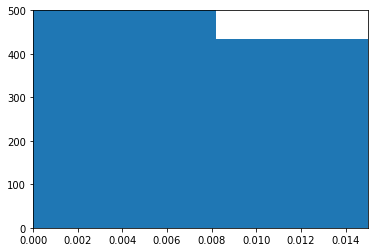

<Figure size 1440x1440 with 0 Axes>

In [57]:
plot(np.abs(c1), y_min=0, y_max=500, x_min=0, x_max=0.015)

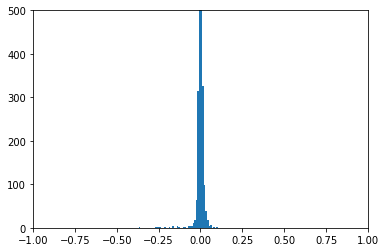

<Figure size 1440x1440 with 0 Axes>

In [43]:
plot(c2, y_min=0, y_max=500, x_min=-1, x_max=1)